In [ ]:
import numpy as np 
import numba
import random
import matplotlib

In [ ]:
GRID_SIZE = 100
SEED = (GRID_SIZE/2, GRID_SIZE/2)

# loop per particle
# 
particle = (np.random(GRID_SIZE), np.random(GRID_SIZE))

#movement random up down, right left unbiased
# when it comes to contact with cluster it attaches and stops moving 


# Attachment points are determined by nearest contact or interaction with other particles in the cluster.
# attaches at one unit distance with cluster




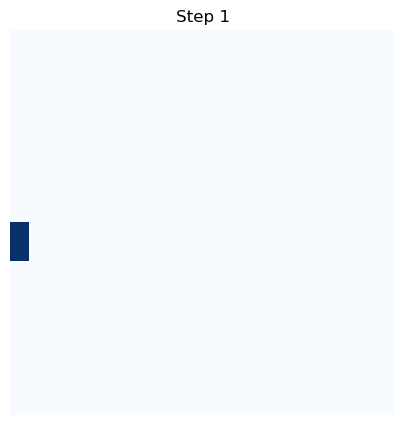